In [14]:
from abc import ABCMeta, abstractmethod
from dataclasses import dataclass
from typing import Optional
import matplotlib.pyplot as plt
import pandas as pd
from os import path
import itertools as it


@dataclass
class LossHistory:
    filename: str
    delimiter: str
    resolution: int

    def data(self) -> pd.DataFrame:
        return pd.read_csv(self.filename, delimiter=self.delimiter)

    def experiment_name(self) -> str:
        return path.basename(path.dirname(self.filename))


class LossHistoryV1 (LossHistory):
    def __init__(self, filename: str):
        super().__init__(filename, ' ', 10)


class LossHistoryV2(LossHistory):
    def __init__(self, filename: str, resolution: int):
        super().__init__(filename, ';', resolution)


loss_csvs: list[LossHistory] = [
    LossHistoryV1(
        '/home/aq85800/NewVolume/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap/loss_history.csv'),
    LossHistoryV2('/home/aq85800/NewVolume/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_losslogger/loss_history.csv', resolution=1),
    LossHistoryV2('/home/aq85800/NewVolume/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_lossdict/loss_history.csv', resolution=10),
    LossHistoryV2('/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_lossdict+emalog/loss_history.csv', resolution=10),
]

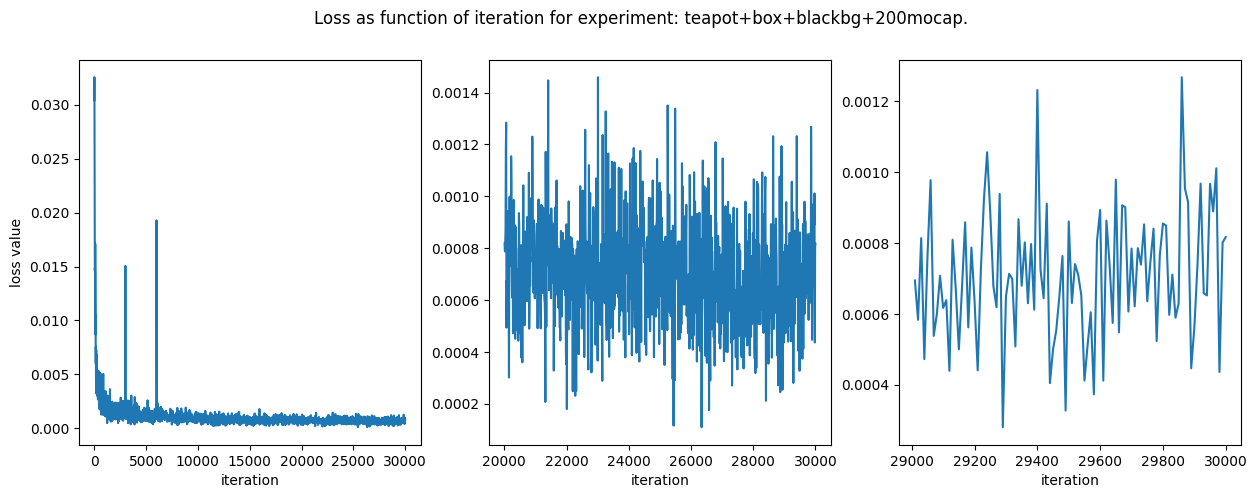

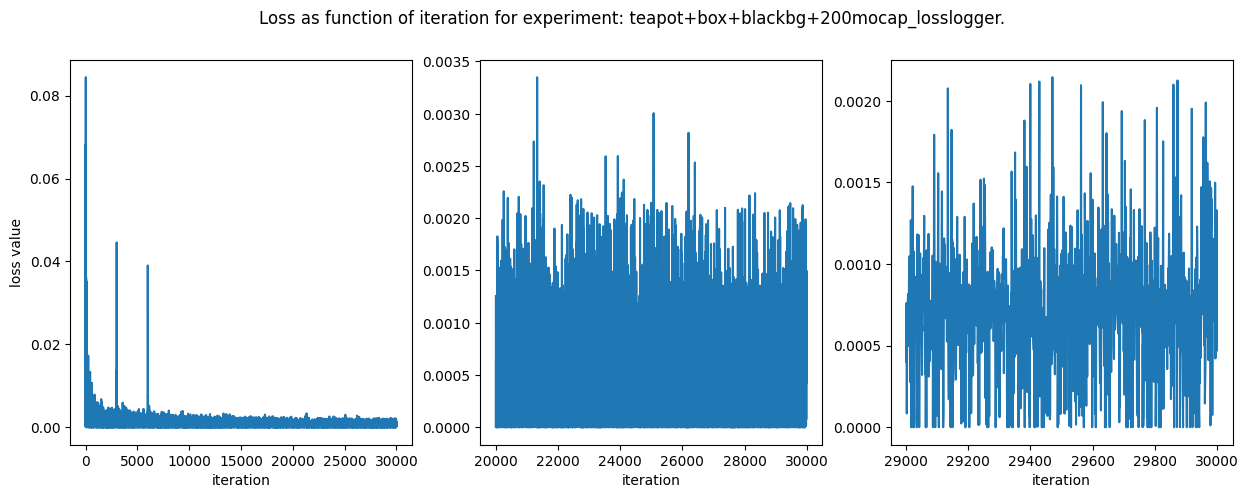

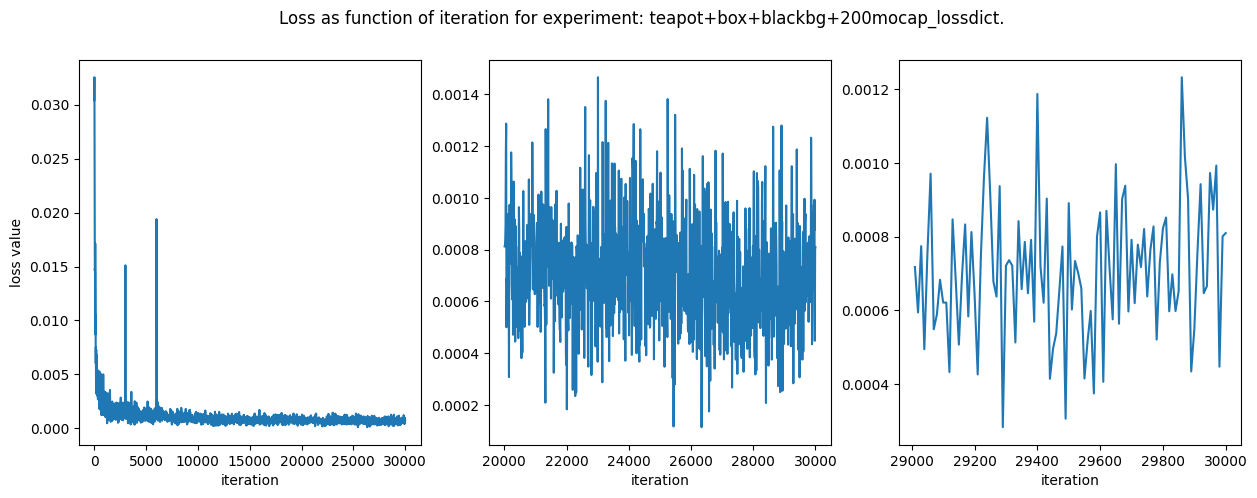

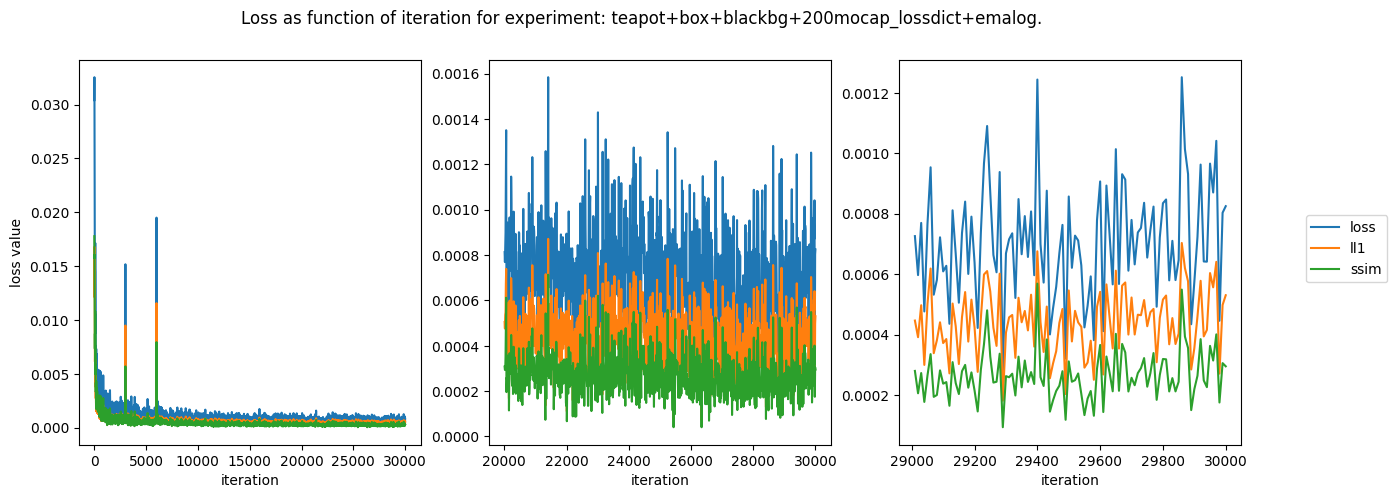

In [15]:
for csv in loss_csvs:
    fig, axs = plt.subplots(1,3,figsize=(15, 5))
    fig.suptitle(f"Loss as function of iteration for experiment: {csv.experiment_name()}.")
    axs[0].set_ylabel('loss value')
    data = csv.data()
    for i,tail in enumerate([30000, 10000, 1000]):
        tail_resolution = tail // csv.resolution
        axs[i].set_xlabel('iteration')
        if 'loss_name' not in data.columns:
            axs[i].plot(data['iteration'].tail(tail_resolution), data['loss'].tail(tail_resolution))
        else:
            for name in data['loss_name'].unique():
                loss_name_mask = data['loss_name'] == name
                loss_name_data = data[loss_name_mask]
                axs[i].plot(loss_name_data['iteration'].tail(tail_resolution), loss_name_data['loss'].tail(tail_resolution), label=name)
    if 'loss_name' in data.columns:
        unique = data['loss_name'].unique()
        if len(unique) > 1:
            fig.legend(labels=unique, loc='center right')
    fig.show()

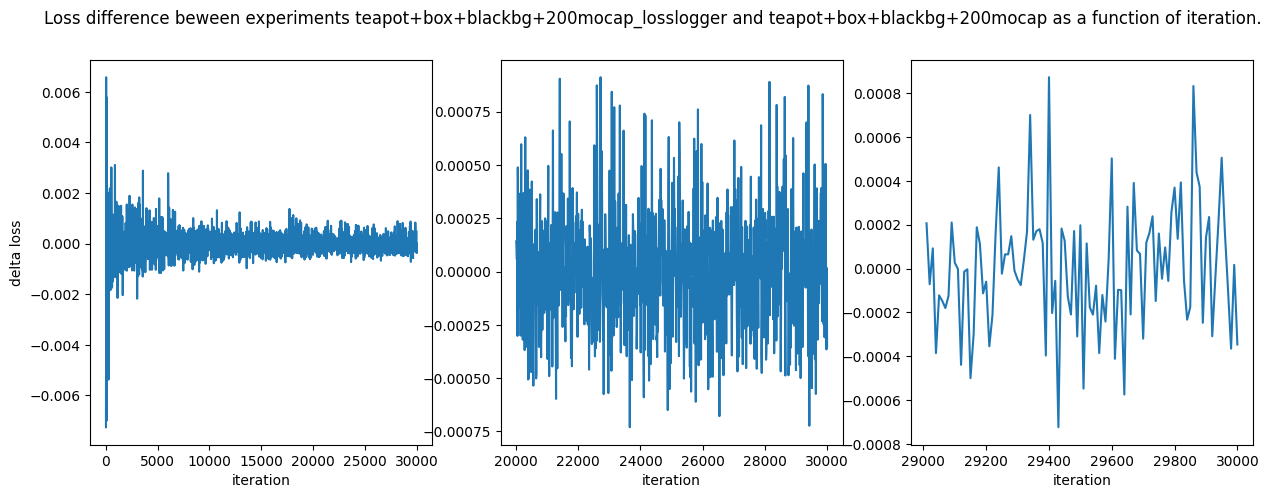

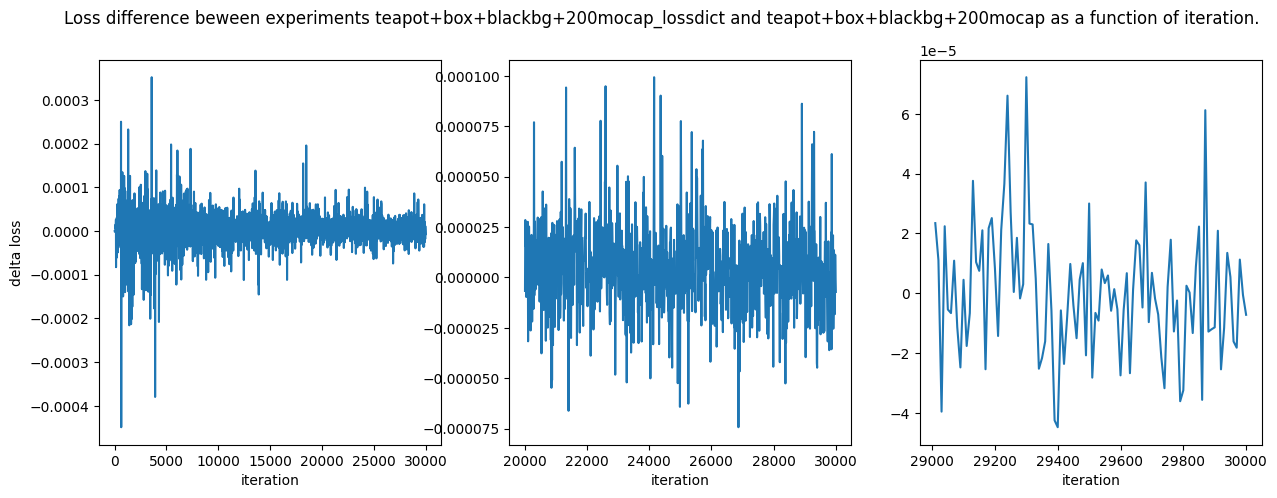

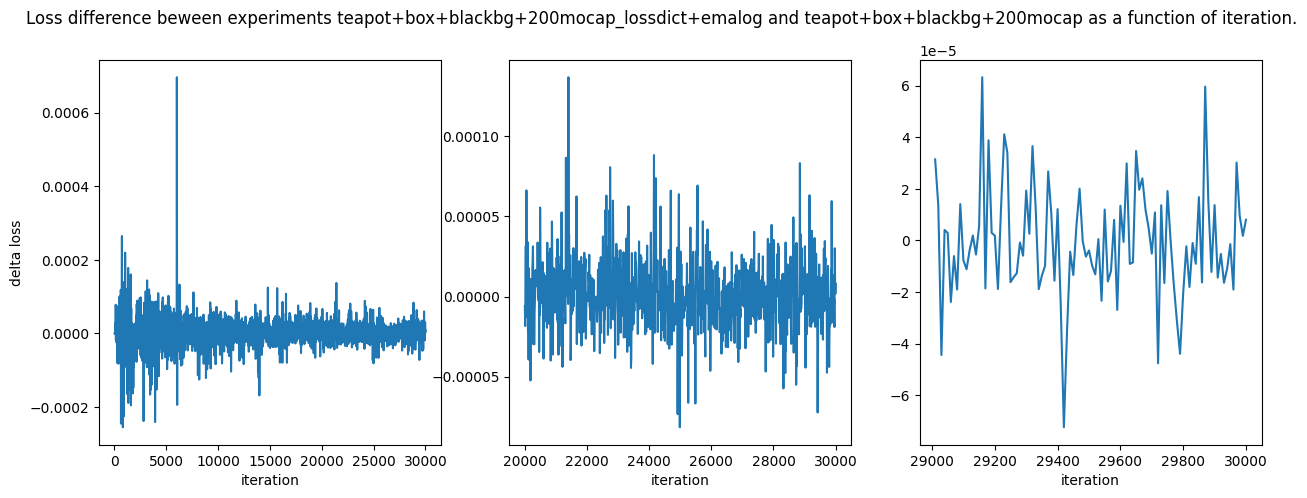

In [16]:
from math import lcm

for csv in loss_csvs[1:]:
    refdata = loss_csvs[0].data()
    if 'loss_name' in refdata.columns:
        refdata = refdata[refdata['loss_name'] == 'loss']
    data = csv.data()
    if 'loss_name' in data.columns:
        data = data[data['loss_name'] == 'loss']

    common_sample_granularity = lcm(csv.resolution, loss_csvs[0].resolution)
    if csv.resolution < loss_csvs[0].resolution:
        resolution_mask = data['iteration'] % common_sample_granularity == 0
        data = data[resolution_mask]
    else:
        resolution_mask = refdata['iteration'] % common_sample_granularity == 0
        refdata = refdata[resolution_mask]
    delta_loss = data['loss'].reset_index(drop=True) - refdata['loss'].reset_index(drop=True)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(
        f"Loss difference beween experiments {csv.experiment_name()} and {loss_csvs[0].experiment_name()} as a function of iteration.")
    axs[0].set_ylabel('delta loss')
    for i, tail in enumerate([30000, 10000, 1000]):
        tail_resolution = tail // common_sample_granularity
        axs[i].set_xlabel('iteration')
        axs[i].plot(data['iteration'].tail(tail_resolution),
                    delta_loss.tail(tail_resolution))

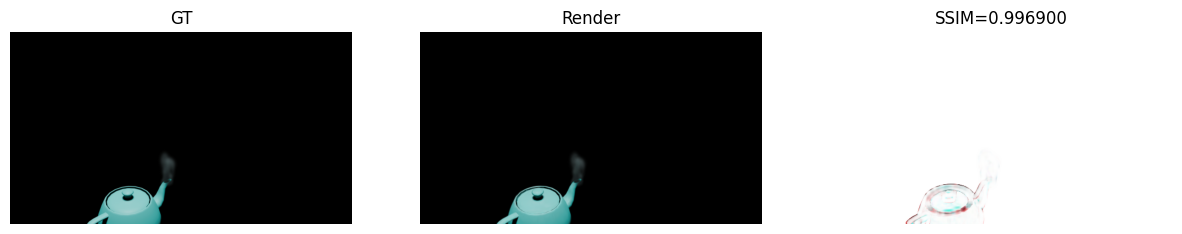

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

gt: np.ndarray = plt.imread(
    "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/gt/00047.png")
render: np.ndarray = plt.imread(
    "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/renders/00047.png")
ssim_metrics, ssim_image = ssim(
    gt, render, channel_axis=2, data_range=gt.max() - gt.min(), full=True)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, title, image in zip(axs, ["GT", "Render", f"SSIM={ssim_metrics:.6f}"], [gt, render, ssim_image]):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)

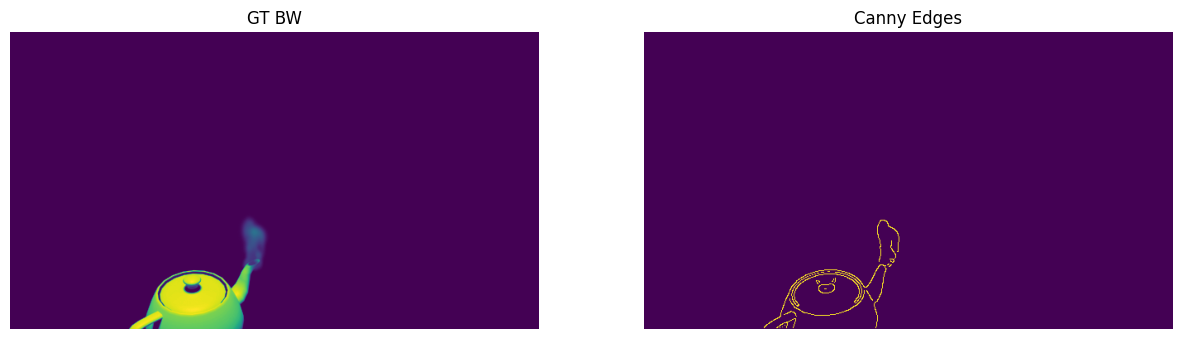

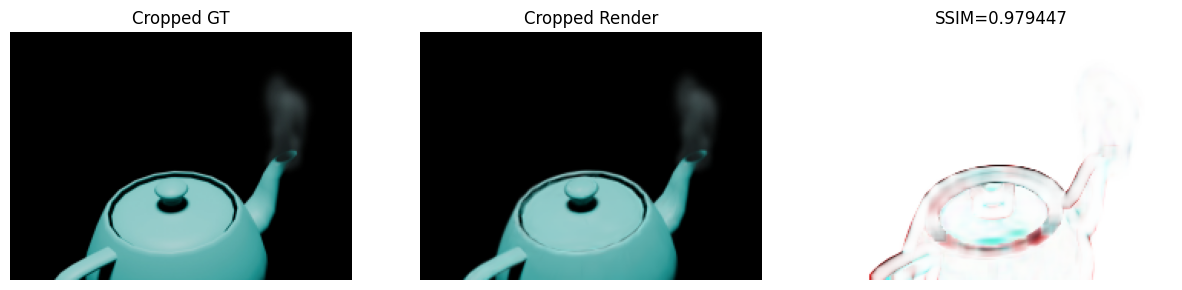

In [ ]:
# canny filter contour extraction
from skimage import feature
from skimage.color import rgb2gray

gt_bw = rgb2gray(gt)
edges: np.ndarray = feature.canny(gt_bw)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, title, image in zip(axs, ["GT BW", "Canny Edges"], [gt_bw, edges]):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)


def crop_to_edges(image: np.ndarray, edges: np.ndarray, padding=0) -> np.ndarray:
    y, x = np.where(edges)
    return image[y.min() - padding:y.max() + padding,  x.min() - padding: x.max() + padding]


cropped_render = crop_to_edges(render, edges, 30)
cropped_gt = crop_to_edges(gt, edges, 30)
ssim_metrics, ssim_image = ssim(
    cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min(), full=True)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, title, image in zip(axs, ["Cropped GT", "Cropped Render", f"SSIM={ssim_metrics:.6f}"], [cropped_gt, cropped_render, ssim_image]):
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)

In [19]:
import functools
from timeit import timeit
from typing import Any, Callable


def ssim_full(**kwargs):
    return ssim(
        gt, render, channel_axis=2, data_range=gt.max() - gt.min(), **kwargs)


def ssim_edge_crop(**kwargs):
    gt_bw = rgb2gray(gt)
    edges: np.ndarray = feature.canny(gt_bw)
    cropped_render = crop_to_edges(render, edges, 30)
    cropped_gt = crop_to_edges(gt, edges, 30)
    return ssim(
        cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min(), **kwargs)


def memoize_custom_hash(func, custom_hash):
    cache = {}

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        key = custom_hash(*args, **kwargs)
        return cache.setdefault(key, func(*args, **kwargs))
    return wrapper


def hash_ndarray(array: np.ndarray):
    return hash(array.tobytes())


def find_edges(gt: np.ndarray):
    gt_bw = rgb2gray(gt)
    edges: np.ndarray = feature.canny(gt_bw)
    return edges


find_edges = memoize_custom_hash(find_edges, hash_ndarray)


def ssim_cached_edge_crop():
    edges = find_edges(gt)
    cropped_render = crop_to_edges(render, edges, 30)
    cropped_gt = crop_to_edges(gt, edges, 30)
    return ssim(
        cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min())

test = (ssim_full(), ssim_edge_crop(), ssim_cached_edge_crop())
print("SSIMs:", test)
eps = 1e-6
for t in test[1:]:
    assert test[1]-eps < t < test[1]+eps, f"SSIM values are not equal: {test}"

import pathlib
gts = [plt.imread(f) for f in sorted(pathlib.Path(
    "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/gt").glob("*.png"))]
renders = [plt.imread(f) for f in sorted(pathlib.Path(
    "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/renders").glob("*.png"))]
for i, (gt, render) in enumerate(zip(gts, renders)):
    test = (ssim_full(), ssim_edge_crop(), ssim_cached_edge_crop())
    print(f"SSIMs of {i}:", test)

number = int(1e3)
times = (
    timeit(
        setup="from __main__ import ssim_full",
        stmt="""ssim_full()""",
        number=number,
    ),
    timeit(
        setup="from __main__ import ssim_edge_crop",
        stmt="""ssim_edge_crop()""",
        number=number,
    ),
    timeit(
        setup="from __main__ import ssim_cached_edge_crop",
        stmt="""ssim_cached_edge_crop()""",
        number=number,
    ),
)
for t, expname in zip(times, ("ssim_full", "ssim_edge_crop", "ssim_cached_edge_crop")):
    print(f"{expname:30}: {t:.6f} seconds")

SSIMs: (np.float32(0.9968999), np.float32(0.9794466), np.float32(0.9794466))
SSIMs of 0: (np.float32(0.99746394), np.float32(0.9765435), np.float32(0.9765435))
SSIMs of 1: (np.float32(0.9975922), np.float32(0.97792166), np.float32(0.97792166))
SSIMs of 2: (np.float32(0.9976937), np.float32(0.97885203), np.float32(0.97885203))
SSIMs of 3: (np.float32(0.99774307), np.float32(0.9794812), np.float32(0.9794812))
SSIMs of 4: (np.float32(0.99774456), np.float32(0.9796687), np.float32(0.9796687))
SSIMs of 5: (np.float32(0.99776906), np.float32(0.98005885), np.float32(0.98005885))
SSIMs of 6: (np.float32(0.99777126), np.float32(0.9800785), np.float32(0.9800785))
SSIMs of 7: (np.float32(0.99776435), np.float32(0.9801832), np.float32(0.9801832))
SSIMs of 8: (np.float32(0.99768335), np.float32(0.9796352), np.float32(0.9796352))
SSIMs of 9: (np.float32(0.9976812), np.float32(0.97978336), np.float32(0.97978336))
SSIMs of 10: (np.float32(0.99760216), np.float32(0.97926444), np.float32(0.97926444))
SS